In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import cluster
import os
import re
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
os.getcwd()


'c:\\Users\\dscshap3808\\Documents\\my_scripts_new\\play1'

In [2]:
df = pd.read_csv('./daily_kpi_all_810.csv')
# df.dropna(axis = 1, inplace = True, how = 'all')
# re1 = re.compile(r'(?<=\.).+')
# df.columns = [re1.findall(i)[0] for i in list(df.columns.to_numpy())]
# df.to_csv('./dws_dsc_wh_ou_daily_kpi_july.csv', encoding='utf_8_sig')

# df.to_csv('./daily_kpi_all_810.csv', encoding='utf_8_sig')

In [3]:
df.columns

Index(['Unnamed: 0', 'ou_code', 'ou_name', 'bg_code', 'bg_name_cn',
       'customer_id', 'customer_name', 'total_storage_location_count',
       'operation_day', 'week', 'month', 'quarter', 'year', 'is_holiday',
       'inbound_header_count', 'inbound_line_count',
       'inbound_line_original_qty', 'inbound_receive_qty',
       'inbound_receive_volume', 'inbound_receive_weight',
       'outbound_header_count', 'outbound_line_count',
       'outbound_line_original_qty', 'outbound_shipped_qty',
       'outbound_shipped_volume', 'outbound_shipped_weight',
       'outbound_std_shipped_volume', 'outbound_std_shipped_weight',
       'used_storage_location_count', 'active_lpn_count', 'on_hand_qty',
       'in_transit_qty', 'allocated_qty', 'total_head_count',
       'total_working_hour', 'outsource_working_hour', 'perm_working_hour',
       'other_working_hour', 'direct_working_hour', 'indirect_working_hour',
       'outbound_inbound_qty_ratio', 'perm_working_hour_ratio',
       'working_ho

[Text(12, 0, '12'),
 Text(15, 0, '15'),
 Text(18, 0, '18'),
 Text(21, 0, '21'),
 Text(24, 0, '24'),
 Text(27, 0, '27'),
 Text(30, 0, '30'),
 Text(33, 0, '33'),
 Text(36, 0, '36'),
 Text(39, 0, '39'),
 Text(42, 0, '42'),
 Text(45, 0, '45'),
 Text(48, 0, '48'),
 Text(51, 0, '51'),
 Text(54, 0, '54'),
 Text(57, 0, '57'),
 Text(60, 0, '60'),
 Text(63, 0, '63'),
 Text(66, 0, '66'),
 Text(69, 0, '69'),
 Text(72, 0, '72'),
 Text(75, 0, '75'),
 Text(78, 0, '78')]

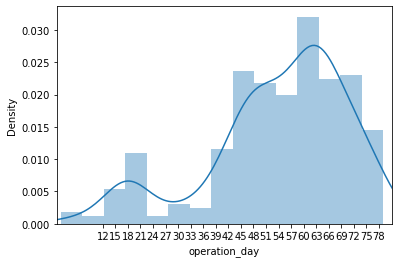

In [4]:
fig, ax = plt.subplots()
sns.distplot(df.groupby('ou_code')['operation_day'].nunique(), ax = ax)

ax.set_xlim(1,81)
ax.set_xticks(np.arange(12,81,3))
ax.set_xticklabels(np.arange(12,81,3), rotation=1)

In [5]:
clean_df1 = (df.groupby('ou_code')['operation_day'].count() < 24).reset_index()
clean_df1.columns = ['ou_code', 'flag1']
df = clean_df1.merge(df, on = 'ou_code', how = 'inner')
df = df[df['flag1'] == False]

clean_df2 = df.groupby('ou_code')[[
    'inbound_receive_qty', 'outbound_shipped_qty'
    ]].sum().reset_index()
clean_df2['sum'] = clean_df2.sum(axis = 1)
clean_df2 = clean_df2[clean_df2['sum'] != 0]
df = df[df['ou_code'].isin(clean_df2.ou_code)]

clean_df3 = (df.groupby('ou_code')[[
    'total_working_hour'
    ]].sum() == 0).reset_index()
clean_df3 = clean_df3[clean_df3['total_working_hour'] == False]
df = df[df['ou_code'].isin(clean_df3.ou_code)]
df= df.reset_index()


In [6]:
df = df[[
    'ou_code','operation_day', 'inbound_receive_qty', 'is_holiday',
    'outbound_shipped_qty','total_head_count','total_working_hour',
    'outsource_working_hour', 'perm_working_hour',
    'other_working_hour', 'direct_working_hour', 'indirect_working_hour',
    'outbound_inbound_qty_ratio', 'perm_working_hour_ratio',
    'working_hour_per_head', 'location_usage_rate', 'location_idle_rate']]
df = df.fillna(0)
df = df[df['total_working_hour'] != 0]

In [8]:

def mnb_kmeans_in(ou_code):
        """
        mini batch kmeans, inbound, outbound, working hour data.
        simple algorithm, adding cols {max, min, mean, median, 75 quantile, distance to kernal}
        """

        alg1 = cluster.MiniBatchKMeans(n_clusters = 4, random_state = 529)
        """
        null data fill
        """
        df_fin = pd.DataFrame()
        df_sub = df[df['ou_code'] == ou_code][['ou_code', 'operation_day', 'inbound_receive_qty']]        
        df_fin = df_fin.append(df_sub[df_sub['inbound_receive_qty'] == 0])
        df_fin['kernal_core1' ] = -1
        df_fin['kernal_value1'] = 0
        """
        not null data training
        """
        df_rec = df_sub[df_sub['inbound_receive_qty'] != 0]      
        hist1 = alg1.fit(np.reshape(list(df_rec['inbound_receive_qty']), (-1,1)))
        df_rec['kernal_core1'] = hist1.labels_
        cl_1 = pd.concat(
                [pd.DataFrame(hist1.cluster_centers_), pd.Series(np.arange(0,4))], axis = 1
                )
        
        cl_1.columns = ['kernal_value1', 'kernal_core1']
        df_rec = df_rec.merge(
                cl_1, on = 'kernal_core1', how = 'inner'
                )
        
        """
        merging
        """
        df_fin = df_fin.append(df_rec).reset_index().drop(['index'], axis = 1)

        # df_fin['kind'] = 'inbound'

        return df_fin


def mnb_kmeans_out(ou_code):
        alg1 = cluster.MiniBatchKMeans(n_clusters = 4, random_state = 707)
        df_fin = pd.DataFrame()
        df_sub = df[df['ou_code'] == ou_code][['ou_code', 'operation_day', 'outbound_shipped_qty']]        
        df_fin = df_fin.append(df_sub[df_sub['outbound_shipped_qty'] == 0])
        df_fin['kernal_core2' ] = -1
        df_fin['kernal_value2'] = 0
        df_rec = df_sub[df_sub['outbound_shipped_qty'] != 0]

        hist1 = alg1.fit(np.reshape(list(df_rec['outbound_shipped_qty']), (-1,1)))

        df_rec['kernal_core2'] = hist1.labels_
        cl_1 = pd.concat(
                [pd.DataFrame(hist1.cluster_centers_), pd.Series(np.arange(0,4))], axis = 1
                )
        
        cl_1.columns = ['kernal_value2', 'kernal_core2']

        df_rec = df_rec.merge(
                cl_1, on = 'kernal_core2', how = 'inner'
                )
        df_fin = df_fin.append(df_rec).reset_index().drop(['index'], axis = 1)
        # df_fin['kind'] = 'outbound'
        return df_fin

def mnb_kmeans_hr(ou_code):
        alg1 = cluster.MiniBatchKMeans(n_clusters = 4, random_state = 5290707)
        df_fin = pd.DataFrame()
        df_sub = df[df['ou_code'] == ou_code][['ou_code', 'operation_day', 'total_working_hour']]        
        df_fin = df_fin.append(df_sub[df_sub['total_working_hour'] == 0])
        df_fin['kernal_core3' ] = -1
        df_fin['kernal_value3'] = 0
        df_rec = df_sub[df_sub['total_working_hour'] != 0]

        hist1 = alg1.fit(np.reshape(list(df_rec['total_working_hour']), (-1,1)))

        df_rec['kernal_core3'] = hist1.labels_
        cl_1 = pd.concat(
                [pd.DataFrame(hist1.cluster_centers_), pd.Series(np.arange(0,4))], axis = 1
                )
        
        cl_1.columns = ['kernal_value3', 'kernal_core3']

        df_rec = df_rec.merge(
                cl_1, on = 'kernal_core3', how = 'inner'
                )
        df_fin = df_fin.append(df_rec).reset_index().drop(['index'], axis = 1)

        # df_fin['kind'] = 'working_hour'
        # df_fin['max_wh']    = df_fin.groupby('kernal_core3')['total_working_hour'].transform('max')
        # df_fin['min_wh']    = df_fin.groupby('kernal_core3')['total_working_hour'].transform('min')
        # df_fin['median_wh'] = df_fin.groupby('kernal_core3')['total_working_hour'].transform('median')
        # df_fin['mean_wh']   = df_fin.groupby('kernal_core3')['total_working_hour'].transform('mean')
        # df_fin['qt_66_wh']  = df_fin.groupby('kernal_core3')['total_working_hour'].transform('quantile', .66)
        # df_fin['qt_75_wh']  = df_fin.groupby('kernal_core3')['total_working_hour'].transform('quantile', .75)
        """
        组内kernal distance 
        """
        df_fin['dis_core']  = df_fin.groupby(
                'kernal_core3', as_index = False, observed = True
                )['total_working_hour','kernal_value3'].agg('diff', axis = 1).drop('total_working_hour', axis = 1).round(3)
        return df_fin
   

In [9]:
ou_codes = list(df['ou_code'].unique())
p = list()
for i in ou_codes:
    try: 
        mnb_kmeans_in(i)
        mnb_kmeans_out(i)
        mnb_kmeans_hr(i)
    except:
        
        p.append(i)


for i in p:
    ou_codes.remove(i)
 

In [11]:
p

['CN-009',
 'CN-030',
 'CN-057',
 'CN-070',
 'CN-149',
 'CN-177',
 'CN-189',
 'CN-202',
 'CN-242',
 'CN-246',
 'CN-258',
 'CN-306',
 'CN-374',
 'CN-376',
 'CN-377',
 'CN-378',
 'CN-380',
 'CN-381',
 'CN-411',
 'CN-417',
 'CN-421',
 'CN-425',
 'HK-008',
 'HK-015',
 'HK-051']

In [12]:
# ou_codes = list(df['ou_code'].unique())
# ou_codes.remove('CN-009')
# ou_codes.remove('CN-070')
# ou_codes.remove('CN-149')
# ou_codes.remove('CN-189')
# ou_codes.remove('CN-242')
# ou_codes.remove('CN-374')
# ou_codes.remove('CN-378')
# ou_codes.remove('CN-417')
# ou_codes.remove('HK-015')
# # ou_codes = [i for i in ou_codes if re.match(r'HK', i) is None] 
# ou_codes

In [13]:
%%time
from functools import reduce
df_final = pd.DataFrame()
for i in ou_codes:
        df_final = df_final.append(
            reduce(
                lambda left,right: pd.merge(
                    left,right,on= ['ou_code', 'operation_day']
                ), [mnb_kmeans_in(i), mnb_kmeans_out(i), mnb_kmeans_hr(i)]
                )
    )

"""
for loop , 对所有ou进行独立的kmeans on inb qty and outb qty
随后merge 原始表
"""

# np.setdiff1d(ou_codes,df_final.ou_code.unique())
df_final = df_final.merge(
    df[['ou_code','operation_day','outbound_inbound_qty_ratio','working_hour_per_head','total_head_count','is_holiday']],
    on = ['ou_code', 'operation_day'],
    how = 'left'
    )


Wall time: 10.1 s


In [14]:
df_final

,ou_code,operation_day,inbound_receive_qty,kernal_core1,kernal_value1,outbound_shipped_qty,kernal_core2,kernal_value2,total_working_hour,kernal_core3,kernal_value3,dis_core,outbound_inbound_qty_ratio,working_hour_per_head,total_head_count,is_holiday
0,CN-001,20210619,0.0,-1,0.000000,0.0,-1,0.000000,30.00,1,31.744802,1.745,0.000000,10.000000,3.0,1
1,CN-001,20210626,0.0,-1,0.000000,0.0,-1,0.000000,9.50,2,9.500000,0.000,0.000000,9.500000,1.0,1
2,CN-001,20210625,0.0,-1,0.000000,12819.0,2,13556.152941,32.12,1,31.744802,-0.375,0.000000,8.030000,4.0,0
3,CN-001,20210705,0.0,-1,0.000000,0.0,-1,0.000000,31.58,1,31.744802,0.165,0.000000,7.895000,4.0,0
4,CN-001,20210616,0.0,-1,0.000000,7321.0,1,2658.657561,31.60,1,31.744802,0.145,0.000000,7.900000,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,HK-115,20210716,469.0,0,1829.564597,10006.0,2,7769.547289,81.32,1,83.009650,1.690,21.334755,9.035556,9.0,0
1240,HK-115,20210728,2490.0,0,1829.564597,8298.0,2,7769.547289,58.21,3,62.840374,4.630,3.332530,9.701667,6.0,0
1241,HK-115,20210724,240.0,0,1829.564597,2190.0,0,4103.392744,29.74,2,27.283875,-2.456,9.125000,7.435000,4.0,1
1242,HK-115,20210715,2021.0,0,1829.564597,6827.0,2,7769.547289,82.05,1,83.009650,0.960,3.378031,9.116667,9.0,0


In [15]:
def mutatation_(new_col, calculate_methdo):
    df_final[new_col] = df_final.groupby(
    ['ou_code', 'kernal_core1', 'kernal_core2']
    )['total_working_hour'].transform(calculate_methdo)
    return df_final


In [16]:
df_final['max_wh'] = df_final.groupby(
    ['ou_code', 'kernal_core1', 'kernal_core2']
    )['total_working_hour'].transform('max')
df_final['min_wh'] = df_final.groupby(
    ['ou_code', 'kernal_core1', 'kernal_core2']
    )['total_working_hour'].transform('min')
df_final['median_wh'] = df_final.groupby(
    ['ou_code', 'kernal_core1', 'kernal_core2']
    )['total_working_hour'].transform('median')
df_final['mean_wh'] = df_final.groupby(
    ['ou_code', 'kernal_core1', 'kernal_core2']
    )['total_working_hour'].transform('mean')
df_final['qt_66_wh'] = df_final.groupby(
    ['ou_code', 'kernal_core1', 'kernal_core2']
    )['total_working_hour'].transform('quantile', .6667)
df_final['qt_75_wh'] = df_final.groupby(
    ['ou_code', 'kernal_core1', 'kernal_core2']
    )['total_working_hour'].transform('quantile', .75)
df_final['d_to_core_outer'] = df_final.groupby(
        ['ou_code', 'kernal_core1', 'kernal_core2'], as_index = False, observed = True
                )['total_working_hour','kernal_value3'].agg(
                    'diff', axis = 1
                    ).drop('total_working_hour', axis = 1).round(3)

    # df_final['flag_dis_core'] = df_final['d_to_core_outer'] - df_final['dis_core']>.01
    # return df_final

# df_final= add_calulates()

In [17]:
# [0 if a == 1 else a for a in df_final['percent_error_66']]


In [18]:

df_final['percent_error_66'] = (
        df_final['qt_66_wh'] - df_final['total_working_hour'])/(
                df_final['total_working_hour']
                )
df_final['percent_error_75'] = (
        df_final['qt_75_wh'] - df_final['total_working_hour']
        )/(df_final['total_working_hour']
        )

# df_final = df_final.assign(percent_error_66 = [a-1 if a == 1 else a for a in df_final['percent_error_66']])
# df_final = df_final.assign(percent_error_75 = [a-1 if a == 1 else a for a in df_final['percent_error_75']])


In [19]:
# df_final[df_final['percent_error_75'] != 0].dropna()
from datetime import date
df_final['inc_day'] = str(date.today())
df_final['inc_day'] = df_final['inc_day'].str.replace('-', '')

In [20]:
# df_final.to_csv('./wh_in_out_fin.csv', index= None)

In [21]:
df_final[df_final['percent_error_75'] < -.05]

,ou_code,operation_day,inbound_receive_qty,kernal_core1,kernal_value1,outbound_shipped_qty,kernal_core2,kernal_value2,total_working_hour,kernal_core3,...,max_wh,min_wh,median_wh,mean_wh,qt_66_wh,qt_75_wh,d_to_core_outer,percent_error_66,percent_error_75,inc_day
20,CN-001,20210707,23881.0,1,23397.421922,0.0,-1,0.000000,33.55,3,...,33.55,24.50,29.025,29.025000,30.533635,31.2875,0.312,-0.089907,-0.067437,20210812
26,CN-001,20210623,12699.0,3,11527.301724,23826.0,3,21197.105590,31.87,1,...,31.87,25.00,28.435,28.435000,29.580229,30.1525,-0.125,-0.071847,-0.053891,20210812
38,CN-002,20210630,0.0,-1,0.000000,0.0,-1,0.000000,40.41,0,...,40.41,13.33,26.870,26.870000,31.384236,33.6400,0.436,-0.223355,-0.167533,20210812
44,CN-002,20210706,1.0,2,440.374378,3870.0,1,2569.836639,56.75,1,...,56.75,40.53,41.070,44.146000,41.483416,41.6900,-0.190,-0.269015,-0.265374,20210812
46,CN-002,20210709,16970.0,3,16579.176638,286.0,1,2569.836639,56.85,1,...,56.85,40.66,48.755,48.755000,51.453873,52.8025,-0.290,-0.094919,-0.071196,20210812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,HK-050,20210726,97.0,2,354.023077,2293.0,2,2857.787879,28.32,3,...,28.32,13.58,20.950,20.950000,23.407158,24.6350,0.921,-0.173476,-0.130120,20210812
1208,HK-050,20210730,4519.0,3,4000.608000,2628.0,2,2857.787879,29.12,3,...,29.12,9.00,18.980,19.033333,22.360676,24.0500,0.121,-0.232120,-0.174107,20210812
1231,HK-115,20210712,0.0,-1,0.000000,6890.0,2,7769.547289,60.56,3,...,60.56,34.31,52.840,49.236667,55.413848,56.7000,2.280,-0.084976,-0.063738,20210812
1233,HK-115,20210713,0.0,-1,0.000000,5437.0,0,4103.392744,85.69,1,...,85.69,45.77,53.180,59.455000,53.303239,61.3975,-2.680,-0.377953,-0.283493,20210812


---

---

----

In [22]:
df_final

,ou_code,operation_day,inbound_receive_qty,kernal_core1,kernal_value1,outbound_shipped_qty,kernal_core2,kernal_value2,total_working_hour,kernal_core3,...,max_wh,min_wh,median_wh,mean_wh,qt_66_wh,qt_75_wh,d_to_core_outer,percent_error_66,percent_error_75,inc_day
0,CN-001,20210619,0.0,-1,0.000000,0.0,-1,0.000000,30.00,1,...,31.60,9.50,19.75,20.28,30.526930,31.185,1.745,0.017564,0.039500,20210812
1,CN-001,20210626,0.0,-1,0.000000,0.0,-1,0.000000,9.50,2,...,31.60,9.50,19.75,20.28,30.526930,31.185,0.000,2.213361,2.282632,20210812
2,CN-001,20210625,0.0,-1,0.000000,12819.0,2,13556.152941,32.12,1,...,32.12,32.12,32.12,32.12,32.120000,32.120,-0.375,0.000000,0.000000,20210812
3,CN-001,20210705,0.0,-1,0.000000,0.0,-1,0.000000,31.58,1,...,31.60,9.50,19.75,20.28,30.526930,31.185,0.165,-0.033346,-0.012508,20210812
4,CN-001,20210616,0.0,-1,0.000000,7321.0,1,2658.657561,31.60,1,...,33.08,24.50,32.10,30.80,32.513416,32.720,0.145,0.028906,0.035443,20210812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,HK-115,20210716,469.0,0,1829.564597,10006.0,2,7769.547289,81.32,1,...,82.05,58.21,81.32,73.86,81.563382,81.685,1.690,0.002993,0.004488,20210812
1240,HK-115,20210728,2490.0,0,1829.564597,8298.0,2,7769.547289,58.21,3,...,82.05,58.21,81.32,73.86,81.563382,81.685,4.630,0.401192,0.403281,20210812
1241,HK-115,20210724,240.0,0,1829.564597,2190.0,0,4103.392744,29.74,2,...,43.30,28.21,29.74,33.75,34.260904,36.520,-2.456,0.152014,0.227976,20210812
1242,HK-115,20210715,2021.0,0,1829.564597,6827.0,2,7769.547289,82.05,1,...,82.05,58.21,81.32,73.86,81.563382,81.685,0.960,-0.005931,-0.004449,20210812


In [25]:
%%time

str(date.today()).replace('-', '')

Wall time: 0 ns


'20210812'

In [28]:
df_final

,ou_code,operation_day,inbound_receive_qty,kernal_core1,kernal_value1,outbound_shipped_qty,kernal_core2,kernal_value2,total_working_hour,kernal_core3,...,max_wh,min_wh,median_wh,mean_wh,qt_66_wh,qt_75_wh,d_to_core_outer,percent_error_66,percent_error_75,inc_day
0,CN-001,20210619,0.0,-1,0.000000,0.0,-1,0.000000,30.00,1,...,31.60,9.50,19.75,20.28,30.526930,31.185,1.745,0.017564,0.039500,20210812
1,CN-001,20210626,0.0,-1,0.000000,0.0,-1,0.000000,9.50,2,...,31.60,9.50,19.75,20.28,30.526930,31.185,0.000,2.213361,2.282632,20210812
2,CN-001,20210625,0.0,-1,0.000000,12819.0,2,13556.152941,32.12,1,...,32.12,32.12,32.12,32.12,32.120000,32.120,-0.375,0.000000,0.000000,20210812
3,CN-001,20210705,0.0,-1,0.000000,0.0,-1,0.000000,31.58,1,...,31.60,9.50,19.75,20.28,30.526930,31.185,0.165,-0.033346,-0.012508,20210812
4,CN-001,20210616,0.0,-1,0.000000,7321.0,1,2658.657561,31.60,1,...,33.08,24.50,32.10,30.80,32.513416,32.720,0.145,0.028906,0.035443,20210812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,HK-115,20210716,469.0,0,1829.564597,10006.0,2,7769.547289,81.32,1,...,82.05,58.21,81.32,73.86,81.563382,81.685,1.690,0.002993,0.004488,20210812
1240,HK-115,20210728,2490.0,0,1829.564597,8298.0,2,7769.547289,58.21,3,...,82.05,58.21,81.32,73.86,81.563382,81.685,4.630,0.401192,0.403281,20210812
1241,HK-115,20210724,240.0,0,1829.564597,2190.0,0,4103.392744,29.74,2,...,43.30,28.21,29.74,33.75,34.260904,36.520,-2.456,0.152014,0.227976,20210812
1242,HK-115,20210715,2021.0,0,1829.564597,6827.0,2,7769.547289,82.05,1,...,82.05,58.21,81.32,73.86,81.563382,81.685,0.960,-0.005931,-0.004449,20210812


In [37]:
df_final['kernal_core1'].astype(str) + df_final['kernal_core2'].astype(str) 

0       -1-1
1       -1-1
2        -12
3       -1-1
4        -11
        ... 
1239      02
1240      02
1241      00
1242      02
1243      12
Length: 1244, dtype: object

In [43]:
 import plotly.express as px
 def plot3d(ou_code):
    df_plot = df_final[df_final['ou_code'] == ou_code]
    df_plot['kernal_core5'] = df_final['kernal_core1'].astype(str) + df_final['kernal_core2'].astype(str) 
    fig = px.scatter_3d(df_plot, x='inbound_receive_qty', y='outbound_shipped_qty', z='total_working_hour',
              color = 'kernal_core3')
    return fig.show()


In [44]:
plot3d('CN-214')

In [64]:

fig.show()